In [123]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "7"  # Set the GPU 2 to use

In [124]:
import sys

sys.path.append('../GSL')

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

import os
from glob import glob, escape
import torch.nn as nn
from torch.nn import functional as F

import pickle
import yaml
from easydict import EasyDict as edict

from torch_geometric.utils import to_dense_adj, dense_to_sparse

In [126]:
from utils.scalers import *
from utils.score import *

from utils.result_visualization import get_exp_result_files, get_scaler

In [127]:
exp_dirs = glob('../exp/*_ETTm2_EXP/*')
exp_dirs.sort()
exp_dirs

['../exp/0804_ETTm2_EXP/stacks_3__n_head_4__mlp_stack_512_0805_144640',
 '../exp/0804_ETTm2_EXP/stacks_3__n_head_8__mlp_stack_512_0804_153537',
 '../exp/0804_ETTm2_EXP/stacks_6__n_head_4__mlp_stack_512_0805_144644',
 '../exp/0804_ETTm2_EXP/stacks_6__n_head_8__mlp_stack_512_0804_153541',
 '../exp/0804_ETTm2_EXP/stacks_9__n_head_4__mlp_stack_512_0805_144647',
 '../exp/0804_ETTm2_EXP/stacks_9__n_head_8__mlp_stack_512_0804_153544',
 '../exp/0808_ETTm2_EXP/stacks_3__n_head_4__mlp_stack_1024_0808_150104',
 '../exp/0808_ETTm2_EXP/stacks_6__n_head_4__mlp_stack_1024_0808_150107',
 '../exp/0808_ETTm2_EXP/stacks_9__n_head_4__mlp_stack_1024_0808_150110',
 '../exp/0811_ETTm2_EXP/stacks_3__n_head_16__mlp_stack_1024_0811_214632',
 '../exp/0811_ETTm2_EXP/stacks_3__n_head_16__mlp_stack_1024_0811_214704',
 '../exp/0811_ETTm2_EXP/stacks_3__n_head_16__mlp_stack_1024_0811_215256',
 '../exp/0811_ETTm2_EXP/stacks_3__n_head_16__mlp_stack_256_0811_192806',
 '../exp/0811_ETTm2_EXP/stacks_3__n_head_16__mlp_stack

In [128]:
loss_list = []

for exp in exp_dirs:
    test_result_dirs = glob(escape(exp+'/test_score.pickle'))
    if len(test_result_dirs) == 0:
        loss = 100
    else:    
        test_result = pickle.load(open(test_result_dirs[0], 'rb'))
        loss = test_result['scaled_score']['MAE']
    
    loss_list.append(loss)
    print(f'{exp}     {loss}')
    
loss_list = np.array(loss_list)

../exp/0804_ETTm2_EXP/stacks_3__n_head_4__mlp_stack_512_0805_144640     0.32735392451286316
../exp/0804_ETTm2_EXP/stacks_3__n_head_8__mlp_stack_512_0804_153537     100
../exp/0804_ETTm2_EXP/stacks_6__n_head_4__mlp_stack_512_0805_144644     0.36861878633499146
../exp/0804_ETTm2_EXP/stacks_6__n_head_8__mlp_stack_512_0804_153541     100
../exp/0804_ETTm2_EXP/stacks_9__n_head_4__mlp_stack_512_0805_144647     0.347768634557724
../exp/0804_ETTm2_EXP/stacks_9__n_head_8__mlp_stack_512_0804_153544     100
../exp/0808_ETTm2_EXP/stacks_3__n_head_4__mlp_stack_1024_0808_150104     0.3291456401348114
../exp/0808_ETTm2_EXP/stacks_6__n_head_4__mlp_stack_1024_0808_150107     0.3447123169898987
../exp/0808_ETTm2_EXP/stacks_9__n_head_4__mlp_stack_1024_0808_150110     0.3748261332511902
../exp/0811_ETTm2_EXP/stacks_3__n_head_16__mlp_stack_1024_0811_214632     0.3157712519168854
../exp/0811_ETTm2_EXP/stacks_3__n_head_16__mlp_stack_1024_0811_214704     0.3288681209087372
../exp/0811_ETTm2_EXP/stacks_3__n_he

In [129]:
loss_list

array([  0.32735392, 100.        ,   0.36861879, 100.        ,
         0.34776863, 100.        ,   0.32914564,   0.34471232,
         0.37482613,   0.31577125,   0.32886812,   0.3029255 ,
         0.33938691,   0.33605665,   0.33116102,   0.33280271,
         0.35397854,   0.3435863 ,   0.32106417,   0.33271152,
         0.3271144 ,   0.3049871 ,   0.35008964,   0.49358127,
         0.35363168,   0.32756954,   0.32507038,   0.31022254,
         0.34845877,   0.32359442,   0.35652521,   0.34594399,
         0.33049354,   0.3825362 ,   0.30081582,   0.34225079,
         0.31939793,   0.32974821,   0.31791005,   0.3318232 ,
         0.35803452,   0.30867907,   0.31311429,   0.36987737,
         0.34267542])

In [130]:
exp = exp_dirs[np.argmin(loss_list)]

In [131]:
exp

'../exp/0811_ETTm2_EXP/stacks_3__n_head_4__mlp_stack_512_0811_163335'

In [90]:
config, train_result, test_result = get_exp_result_files(exp)

In [92]:
target = test_result['target']
pred = test_result['forecast']

inputs = test_result['inputs']
backcast = test_result['backcast']

per_trend_backcast = test_result['per_trend_backcast']
per_trend_forecast = test_result['per_trend_forecast']

per_seasonality_backcast = test_result['per_seasonality_backcast']
per_seasonality_forecast = test_result['per_seasonality_forecast']

singual_backcast = test_result['singual_backcast']
singual_forecast = test_result['singual_forecast']

In [93]:
scaler = get_scaler('ETTm2', config)

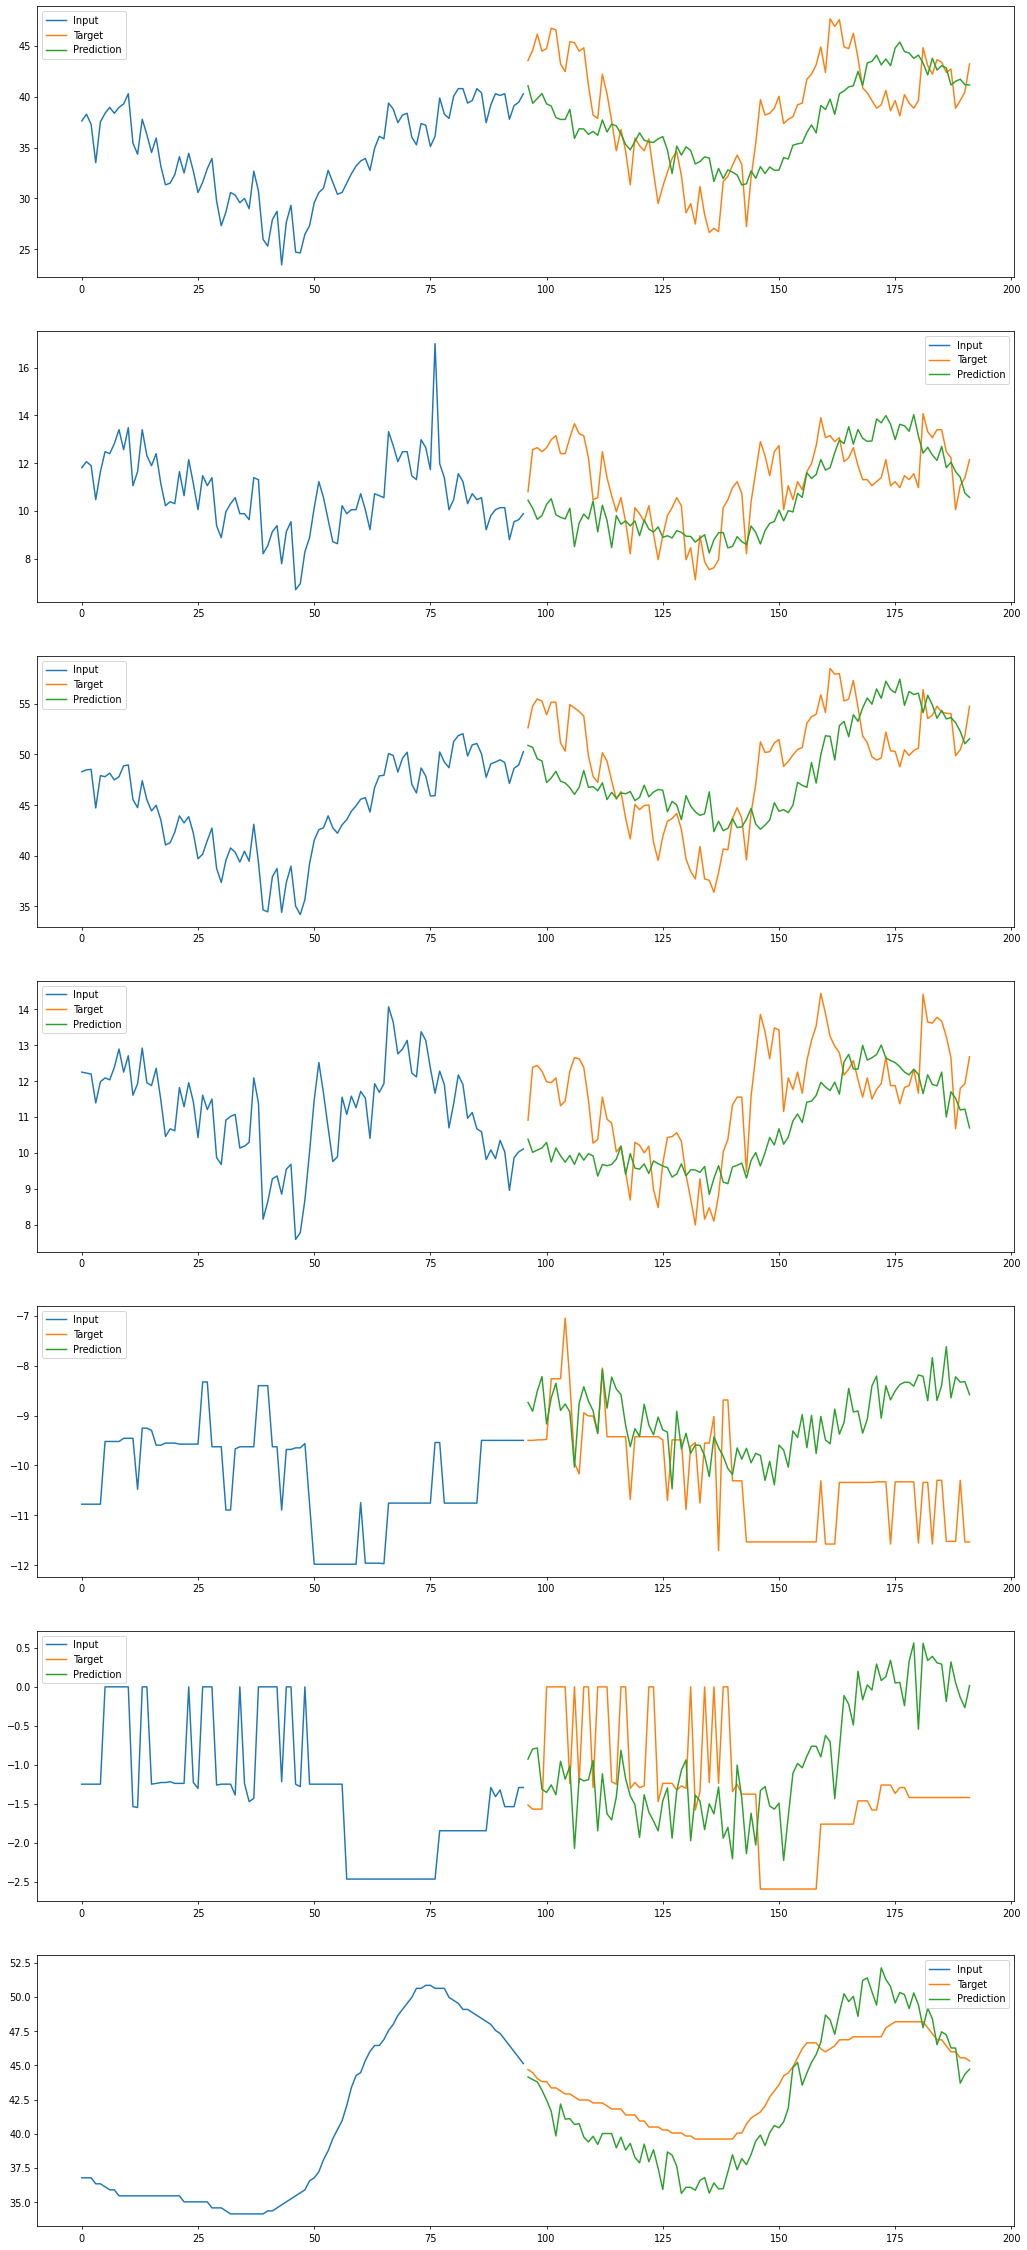

In [96]:
nrow = 7
ncol = 1
batch = -1
node = -3

input_length = config.forecasting_module.backcast_length
output_length = config.forecasting_module.forecast_length

x_axis = np.arange(input_length+output_length)

f, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(18*ncol, 6*nrow), dpi=70)


inv_inputs = scaler.inv_scale(inputs[batch])
inv_backcast = scaler.inv_scale(backcast[batch])
inv_target = scaler.inv_scale(target[batch])
inv_preds = scaler.inv_scale(pred[batch])

for ii in range(nrow):
    axes[ii].plot(x_axis[:input_length], inv_inputs[ii][0], label='Input')
#     axes[ii].plot(x_axis[:input_length], inv_backcast[ii], label='Backcast')

    axes[ii].plot(x_axis[input_length:], inv_target[ii], label='Target')
    axes[ii].plot(x_axis[input_length:], inv_preds[ii], label='Prediction')
    axes[ii].legend()

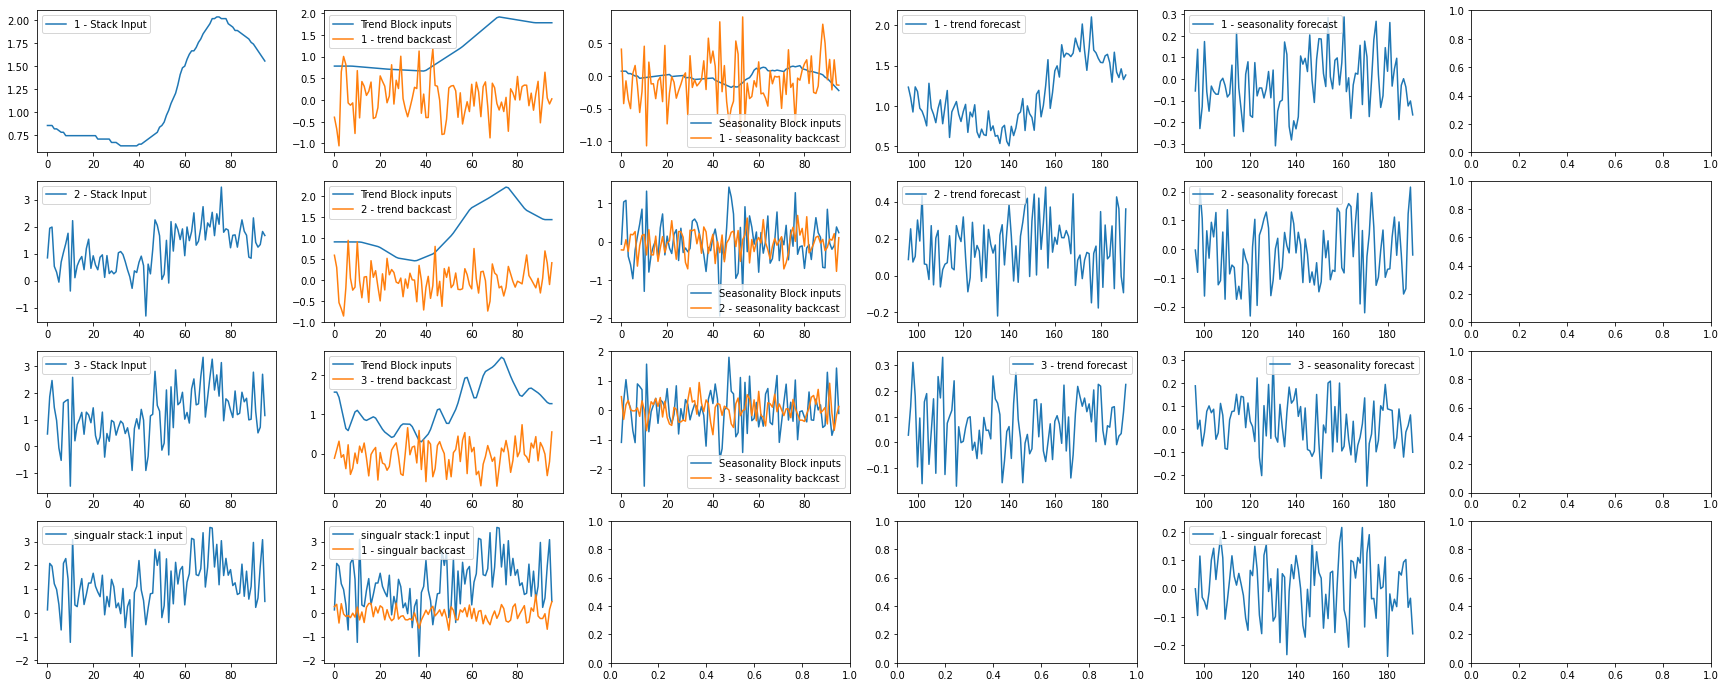

In [97]:
node = -1

nrow = per_trend_backcast.shape[1] + singual_backcast.shape[1]
ncol = 6

input_length = config.forecasting_module.backcast_length
output_length = config.forecasting_module.forecast_length

x_axis = np.arange(input_length+output_length)

f, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(5*ncol, 3*nrow))

inpt = inputs[-1, node, 0]
for ii in range(per_trend_backcast.shape[1]):    
    axes[ii,0].plot(x_axis[:input_length], inpt, label=f'{ii+1} - Stack Input')
    axes[ii,0].legend()
    
    pooling_layer = nn.AvgPool1d(kernel_size=config.forecasting_module.n_pool_kernel_size[ii],
                                              stride=config.forecasting_module.n_pool_kernel_size[ii], 
                                 ceil_mode=False)
    
    pooled_inputs = pooling_layer(torch.Tensor(inpt).unsqueeze(dim=0))

    interpolate_inputs = F.interpolate(pooled_inputs.unsqueeze(dim=1), size=config.forecasting_module.backcast_length,
                                   mode='linear', align_corners=False).squeeze(dim=1)
    
    axes[ii,1].plot(x_axis[:input_length], interpolate_inputs[0], label=f'Trend Block inputs')
    axes[ii,1].legend()
    
        
    axes[ii,2].plot(x_axis[:input_length], inpt-interpolate_inputs[0].numpy(), label=f'Seasonality Block inputs')
    axes[ii,2].legend()
    
    axes[ii,1].plot(x_axis[:input_length], per_trend_backcast[-1,ii][node], label=f'{ii+1} - trend backcast')
    axes[ii,1].legend()
    
    axes[ii,2].plot(x_axis[:input_length], per_seasonality_backcast[-1, ii][node], label=f'{ii+1} - seasonality backcast')
    axes[ii,2].legend()
    
    axes[ii,3].plot(x_axis[input_length:], per_trend_forecast[-1,ii][node], label=f'{ii+1} - trend forecast')
    axes[ii,3].legend()
    
    axes[ii,4].plot(x_axis[input_length:], per_seasonality_forecast[-1, ii][node], label=f'{ii+1} - seasonality forecast')
    axes[ii,4].legend()
    
    inpt = inpt - (per_trend_backcast[-1,ii][node] + per_seasonality_backcast[-1, ii][node])
    
for jj in range(singual_backcast.shape[1]):
    axes[ii+jj+1,0].plot(x_axis[:input_length], inpt, label=f'singualr stack:{jj+1} input')
    axes[ii+jj+1,0].legend()
    
    axes[ii+jj+1,1].plot(x_axis[:input_length], inpt, label=f'singualr stack:{jj+1} input')
    axes[ii+jj+1,1].legend()
    axes[ii+jj+1,1].plot(x_axis[:input_length], singual_backcast[-1,jj][node], label=f'{jj+1} - singualr backcast')
    axes[ii+jj+1,1].legend()
    
    axes[ii+jj+1,4].plot(x_axis[input_length:], singual_forecast[-1,jj][node], label=f'{jj+1} - singualr forecast')
    axes[ii+jj+1,4].legend()

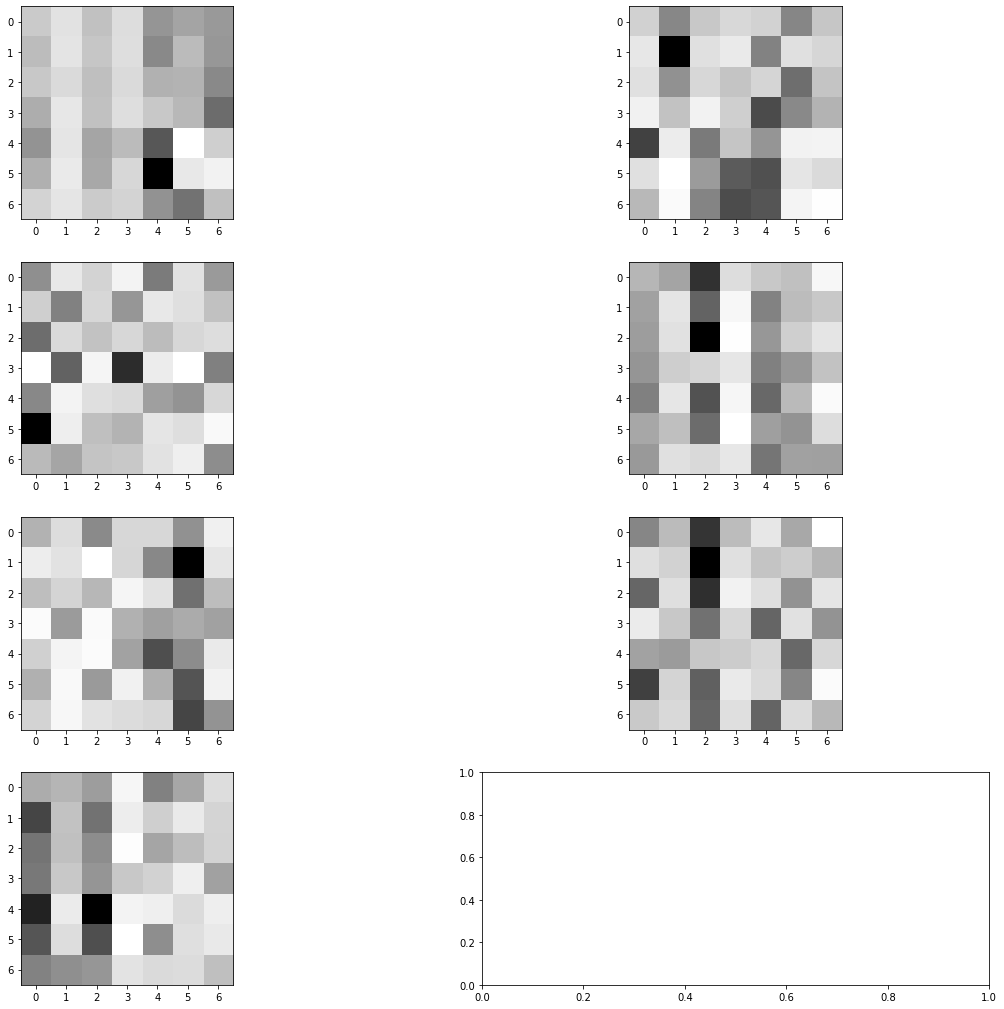

In [99]:
nrows = config.forecasting_module.stack_num+config.forecasting_module.singular_stack_num

fig, axes = plt.subplots(nrows=nrows, ncols=2,
                        figsize=(5*nrows, 3*ncol))

attn = test_result['attention_matrix'][0]

trend_attn = attn['Trend']
season_attn = attn['Seasonality']
singular_attn = attn['Singular']

for ii in range(len(trend_attn)):
    axes[ii, 0].imshow(trend_attn[ii].squeeze(), cmap='Greys')
    axes[ii, 1].imshow(season_attn[ii].squeeze(), cmap='Greys')
    
for i in range(len(singular_attn)):
    axes[ii+i+1, 0].imshow(singular_attn[i].squeeze(), cmap='Greys')